In [1]:
"""

"""

'\n\n'

In [2]:
is_skip = True
# Data params
batch_size = 128

# Model params
d_model = 128
nhead = 4
d_ff = 256
dropout = 0.1
num_layers = 4

# Import

In [3]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

import torch
from pytorch_model_summary import summary

device = torch.device("cuda:0")

# Data

In [4]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [5]:
def preprocess(data):
    data = data.copy()

    # Make sales
    data = data.groupby(["t_dat", "article_id"], as_index=False).agg(sales=("customer_id", "count"))

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["article_id"] = data["article_id"].fillna(method="ffill")
    
    # Data to list
    data = data.groupby("article_id", as_index=False)["sales"].agg(list)
    return data

if not is_skip:
    df_prep = df_raw[df_raw["index_name"]=="Ladieswear"].reset_index(drop=True)
    df_prep = preprocess(df_trans)
    df_prep.to_parquet("df_prep.pq")

In [7]:
df_prep = pd.read_parquet("df_prep.pq")
df_prep["size"] = df_prep["sales"].str.len()
df_prep = df_prep[df_prep["size"] >= 10]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.sales = data["sales"].values
       
    def __len__(self):
        return self.sales.shape[0]
    
    def __getitem__(self, idx):
        sales = self.sales[idx].copy()
        sales = torch.FloatTensor(sales)
        
        decoder_input = sales[:-1].reshape(-1, 1)
        y = sales[1:].reshape(-1, 1)

        # Scale
        decoder_input = np.log1p(decoder_input)
        y = np.log1p(y)

        return {"decoder_input":decoder_input, 
                "y": y}

def collate_fn(batch_li):
    decoder_input = [batch["decoder_input"] for batch in batch_li]
    y = [batch["y"] for batch in batch_li]
    
    decoder_input = torch.nn.utils.rnn.pad_sequence(decoder_input, padding_value=-1, batch_first=True)
    y = torch.nn.utils.rnn.pad_sequence(y, padding_value=-1, batch_first=True)
    
    return {"decoder_input":decoder_input, 
        "y": y}

dataset = Dataset(df_prep)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

for data in dataloader:
    print("decoder_input:", data["decoder_input"].shape)
    print("y:", data["y"].shape)
    break

decoder_input: torch.Size([128, 729, 1])
y: torch.Size([128, 729, 1])


# Architecture

In [8]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, nhead, num_layers):
        super().__init__()
        self.lstm = torch.nn.LSTM(1, d_model)
        self.self_attn = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, batch_first=True), num_layers)
        self.linear = torch.nn.Linear(d_model, 1)

    def get_paddingmask(self, data):
        return torch.where(data==-1, -torch.inf, 0).to(device)

    def forward(self, x):
        # Preparation
        lookahead_mask = torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1]).to(device)
        padding_mask = self.get_paddingmask(x.squeeze(-1))

        # # ------------------------
        # x = x.squeeze(-1)
        # x_sum = x.sum(dim=-1)
        # print(torch.where(x_sum==-731))
        # print(x[1])
        # raise

        # Architecture
        lstm, _ = self.lstm(x)
        self_attn = self.self_attn(lstm, mask=lookahead_mask, src_key_padding_mask=padding_mask, is_causal=True)
        output = self.linear(self_attn)
        return output

model = Transformer(d_model, nhead, num_layers)
model.to(device)
summary(model,
        data["decoder_input"].to(device),
        show_parent_layers=True, print_summary=True)

--------------------------------------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)                                      Output Shape         Param #     Tr. Param #
     Transformer                  LSTM-1     [128, 729, 128], [1, 729, 128], [1, 729, 128]          67,072          67,072
     Transformer    TransformerEncoder-2                                   [128, 729, 128]       2,372,096       2,372,096
     Transformer                Linear-3                                     [128, 729, 1]             129             129
Total params: 2,439,297
Trainable params: 2,439,297
Non-trainable params: 0
--------------------------------------------------------------------------------------------------------------------------


'--------------------------------------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)                                      Output Shape         Param #     Tr. Param #\n==========================================================================================================================\n     Transformer                  LSTM-1     [128, 729, 128], [1, 729, 128], [1, 729, 128]          67,072          67,072\n     Transformer    TransformerEncoder-2                                   [128, 729, 128]       2,372,096       2,372,096\n     Transformer                Linear-3                                     [128, 729, 1]             129             129\n==========================================================================================================================\nTotal params: 2,439,297\nTrainable params: 2,439,297\nNon-trainable params: 0\n----------------------------------------------------

# Train

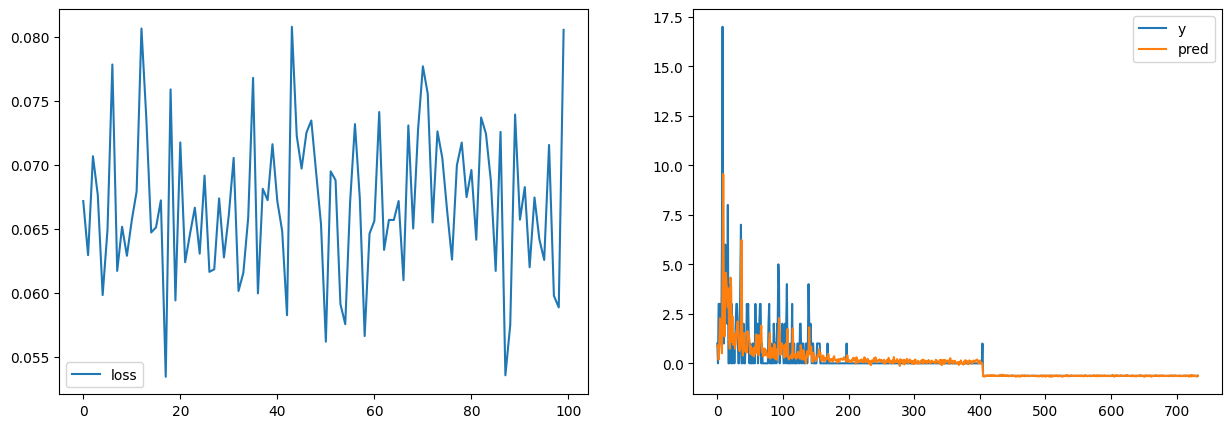

epoch 0 - loss: 0.06692:  44%|████▍     | 337/763 [02:08<02:45,  2.58it/s]

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss()

def loss_fn(y, pred):
    mask = torch.where(y==-1, 0, 1).type(torch.FloatTensor).to(device)
    loss = mse_loss(y, pred)
    masked_loss = loss * mask
    average_loss = masked_loss.sum() / mask.sum()
    return average_loss

class Report():
    def __init__(self, window):
        self.window = window
        self.loss_li = []

    def plot_sample(self, loss_li, y, pred):
        plt.figure(figsize=(15,5))
        nrows, ncols = 1,2

        plt.subplot(nrows, ncols, 1)
        plt.plot(loss_li, label="loss")
        plt.legend()

        plt.subplot(nrows, ncols, 2)
        plt.plot(y, label="y")
        plt.plot(pred, label="pred")
        plt.legend()

        plt.show()

    def report(self, loss, y, pred, pbar, e, isplot=False):
        self.loss_li.append(loss.item())
        pbar.set_description(f"epoch {e} - loss: {np.round(np.mean(self.loss_li[-self.window:]), 5)}")
        
        if isplot:
            clear_output(wait=True)
            self.plot_sample(self.loss_li[-self.window:], y[-1], pred[-1])

def train(e):
    model.train()
    pbar = tqdm(dataloader)
    report = Report(window=100)

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        pred = model(data["decoder_input"].to(device))
        loss = loss_fn(data["y"].to(device), pred)
        loss.backward()
        optimizer.step()

        report.report(loss, 
                    np.expm1(data["y"].squeeze(-1).detach().cpu().numpy()), 
                    np.expm1(pred.squeeze(-1).detach().cpu().numpy()), 
                    pbar, e, isplot=True)
        

epoch = 10
for e in range(epoch):
    train(e)
    break